## Dependencies

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torchvision.datasets import VisionDataset
import skimage.draw
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

## Data Transform and load

### Helper functions

In [2]:


def load_video(filename):
    cap = cv2.VideoCapture(str(filename))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    v = np.zeros((frame_count, frame_height, frame_width, 3), np.uint8)
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        v[i] = frame
    cap.release()
    return v

def get_optimum_set_of_frame_indexes(length, period, target_index, n_frames):
    candidates = [target_index]
    for i in range(length - 1):
        if i % 2 == 0:
            candidates.insert(0, candidates[0] - period)
        else:
            candidates.append(candidates[-1] + period)
    candidates = [i for i in candidates if i < n_frames]
    while len(candidates) < length:
        candidates.insert(0, candidates[0] - period)
    selected_frames = []
    for c in reversed(candidates):
        if c < 0:
            selected_frames.append(selected_frames[-1] + period)
        else:
            selected_frames.insert(0, c)
    return selected_frames

class EchoNetDataset(VisionDataset):
    def __init__(self, root, split="train", length=16, period=2, transform=None, resize=(112, 112)):
        super().__init__(root)
        self.length = length
        self.period = period
        self.transform = transform
        self.resize = resize
        self.root = root

        # Load file list and tracing CSVs
        file_list = pd.read_csv(os.path.join(root, "FileList.csv"))
        tracings = pd.read_csv(os.path.join(root, "VolumeTracings.csv"))

        # Ensure .avi extensions in both
        file_list["FileName"] = file_list["FileName"].apply(lambda x: f"{x}.avi" if not x.endswith(".avi") else x)
        tracings["FileName"] = tracings["FileName"].apply(lambda x: f"{x}.avi" if not x.endswith(".avi") else x)

        # Filter only common files
        common_files = set(file_list["FileName"]) & set(tracings["FileName"])
        self.file_list = file_list[file_list["FileName"].isin(common_files)]
        tracings = tracings[tracings["FileName"].isin(common_files)]

        self.file_list = self.file_list[self.file_list["Split"].str.lower() == split.lower()]
        self.filenames = self.file_list["FileName"].tolist()

        # Build trace dictionary
        self.traces = {}
        for _, row in tracings.iterrows():
            fname = row["FileName"]
            frame = int(row["Frame"])
            coords = (float(row["X1"]), float(row["Y1"]), float(row["X2"]), float(row["Y2"]))
            if fname not in self.traces:
                self.traces[fname] = {}
            if frame not in self.traces[fname]:
                self.traces[fname][frame] = []
            self.traces[fname][frame].append(coords)

        # Convert all coordinate lists to arrays
        self.traces = {
            k: {f: np.array(v[f]) for f in v}
            for k, v in self.traces.items() if len(v) >= 2
        }

        # Final filtering: keep only files that have usable traces
        self.filenames = [f for f in self.filenames if f in self.traces]
        print(f"[EchoNetDataset] Final usable videos: {len(self.filenames)}")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        video_path = os.path.join(self.root, "Videos", filename)
        video = load_video(video_path)  # (T, H, W, 3)
        T, H, W, C = video.shape

        if self.resize:
            video = np.stack([cv2.resize(f, self.resize) for f in video])  # (T, H, W, 3)
            H, W = self.resize[1], self.resize[0]

        if T < self.length * self.period:
            padding = np.zeros((self.length * self.period - T, H, W, 3), dtype=video.dtype)
            video = np.concatenate([video, padding], axis=0)
            T = video.shape[0]

        trace_frames = sorted(self.traces[filename].keys())
        trace_index = trace_frames[len(trace_frames) // 2]  # central traced frame

        frame_idxs = get_optimum_set_of_frame_indexes(self.length, self.period, trace_index, T)
        video_clip = video[frame_idxs]  # (L, H, W, 3)

        # Generate mask for traced frame
        coords = self.traces[filename][trace_index]
        x1, y1, x2, y2 = coords[:, 0], coords[:, 1], coords[:, 2], coords[:, 3]
        x = np.concatenate([x1[1:], np.flip(x2[1:])])
        y = np.concatenate([y1[1:], np.flip(y2[1:])])
        rr, cc = skimage.draw.polygon(np.rint(y).astype(int), np.rint(x).astype(int), (H, W))
        mask = np.zeros((H, W), dtype=np.float32)
        mask[rr, cc] = 1.0

        if self.transform:
            video_clip = np.stack([self.transform(f) for f in video_clip])
            mask = self.transform(mask.astype(np.uint8))

        video_clip = torch.from_numpy(video_clip).permute(3, 0, 1, 2).float() / 255.0  # [C, D, H, W]
        mask = torch.from_numpy(mask).unsqueeze(0).float()  # [1, H, W]

        return video_clip, mask
    

#---------------------------------------Visualize----------------------------------------------------------#

def visualize_random_video_from_loader(loader, max_batches=5):
    """
    Visualizes a random sample from a random batch from a loader.
    Assumes output is (videos, masks) with shapes:
    videos: [B, 3, D, H, W]
    masks:  [B, 1, H, W]
    """
    batch_idx = random.randint(0, max_batches - 1)

    for i, (videos, masks) in enumerate(loader):
        if i != batch_idx:
            continue

        sample_idx = random.randint(0, videos.shape[0] - 1)
        video = videos[sample_idx]  # [3, D, H, W]
        mask = masks[sample_idx][0]  # [H, W]

        video = video.permute(1, 2, 3, 0)  # [D, H, W, C]
        D = video.shape[0]
        grid_size = int(np.ceil(np.sqrt(D)))

        fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))
        fig.suptitle(f"Batch {batch_idx}, Sample {sample_idx}", fontsize=16)

        for i in range(grid_size * grid_size):
            row, col = divmod(i, grid_size)
            ax = axs[row][col]

            if i < D:
                frame = video[i].numpy()
                ax.imshow(frame)
                if i == D // 2:
                    ax.imshow(mask.numpy(), cmap='jet', alpha=0.4)
                    ax.set_title("Center Frame + Mask", fontsize=10)
                else:
                    ax.set_title(f"Frame {i}", fontsize=8)
            ax.axis("off")

        plt.tight_layout()
        plt.show()
        break


### Run

In [3]:
base_path = r"C:\Projects\python\echoframe\data\EchoNet-Dynamic\EchoNet-Dynamic"


dataset = EchoNetDataset(root=base_path, split="train")
loader = DataLoader(dataset, batch_size=4, shuffle=True)

for videos, masks in loader:
    print(videos.shape)  # [4, 3, 16, 112, 112]
    print(masks.shape)   # [4, 1, 112, 112]
    break


[EchoNetDataset] Final usable videos: 7460
torch.Size([4, 3, 16, 112, 112])
torch.Size([4, 1, 112, 112])


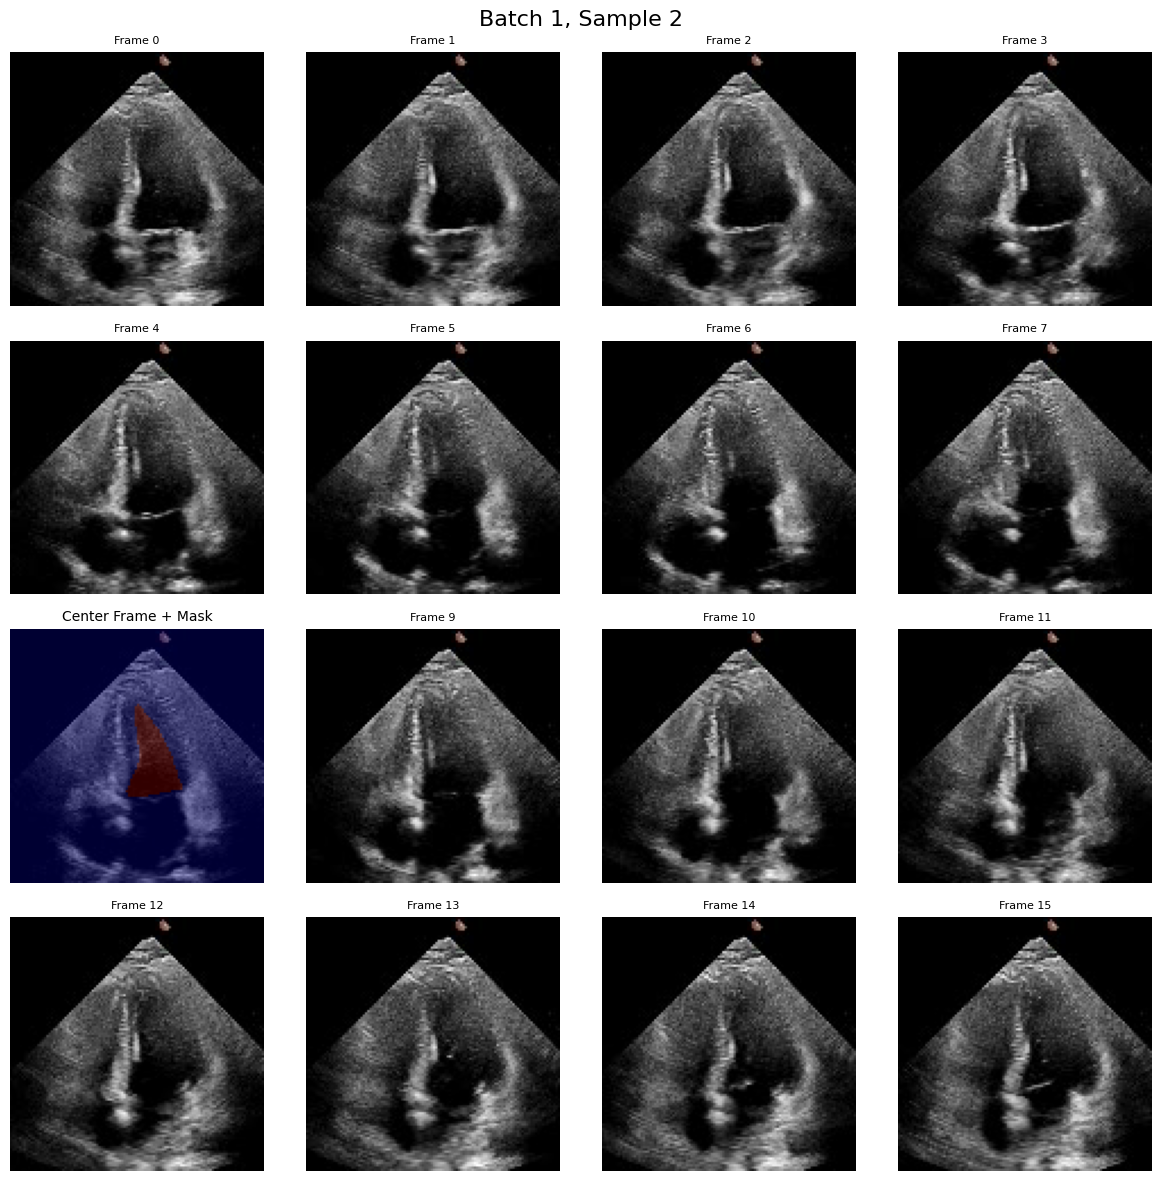

In [7]:
visualize_random_video_from_loader(loader)


## Model

In [1]:
import os
os.chdir('../')

%pwd

'c:\\Projects\\python\\echoframe_capstone'

In [2]:

from src.model9 import MobileNetV3UNet3D
from torchsummary import summary
import torch
net = MobileNetV3UNet3D(in_channels=3, out_channels=1).cuda()
dummy = torch.randn(4, 3, 16, 112, 112).cuda()
out = net(dummy)
summary(model=net,input_size=(3, 16, 112, 112))
print("Output shape:", out.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 16, 112, 112]           1,296
       BatchNorm3d-2     [-1, 16, 16, 112, 112]              32
         Hardswish-3     [-1, 16, 16, 112, 112]               0
            Conv3d-4     [-1, 64, 16, 112, 112]           1,024
       BatchNorm3d-5     [-1, 64, 16, 112, 112]             128
              ReLU-6     [-1, 64, 16, 112, 112]               0
            Conv3d-7       [-1, 64, 16, 56, 56]           1,728
       BatchNorm3d-8       [-1, 64, 16, 56, 56]             128
              ReLU-9       [-1, 64, 16, 56, 56]               0
           Conv3d-10       [-1, 24, 16, 56, 56]           1,536
      BatchNorm3d-11       [-1, 24, 16, 56, 56]              48
InvertedResidual3D-12       [-1, 24, 16, 56, 56]               0
           Conv3d-13       [-1, 72, 16, 56, 56]           1,728
      BatchNorm3d-14       [-1, 72, 16